# Pynkowski for Polarisation Intensity

In this notebook, we can find a small example of how to use the `Pynkowski` package in order to compute the Minkowski Functional of a scalar $P^2$ HEALPix map

In [1]:
import sys 
sys.path.insert(0, "/home/javier/data/work/pynkowski/pynkowski/")
import pynkowski as mf
mf.__file__

'/home/javier/data/work/pynkowski/pynkowski/pynkowski/__init__.py'

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import pynkowski as mf   # For Minkowski Functionals



## Input map

You can use any $P^2$ healpy map such as the Planck ones. In order to make this notebook reproducible without external data, we create a sample map with a simple power spectrum. The only condition (for the second and third MFs) is that it has to be reasonably smooth: the `nside` parameter must be large enough (or `lmax` small enough) for the spatial derivatives to exist. If the results are too noisy, this could be the problem.

In [3]:
nside = 512
ell = np.arange(3*nside - 1)
c_ell = np.zeros((4, 3*nside - 1))
B_E = 0.5 # B/E ratio
#No power in intensity
c_ell[1] = np.exp(-(ell-100)**2 / 5000)
c_ell[2] = B_E * np.exp(-(ell-100)**2 / 5000)

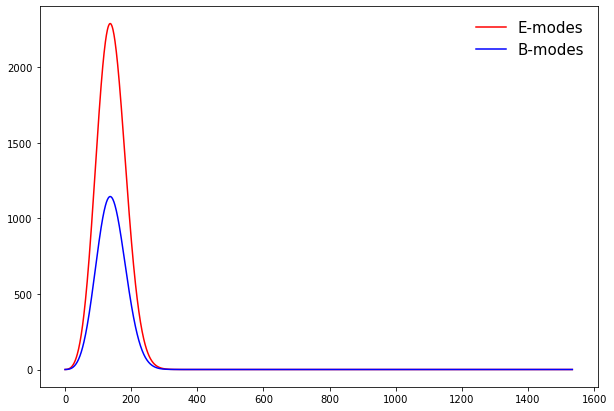

In [4]:
plt.figure(figsize=(10,7))
plt.plot(ell, (c_ell[1])*ell*(ell+1)/(2.*np.pi),'r',label='E-modes')
plt.plot(ell, (c_ell[2])*ell*(ell+1)/(2.*np.pi),'b',label='B-modes')
plt.legend(fontsize=15,frameon=False)

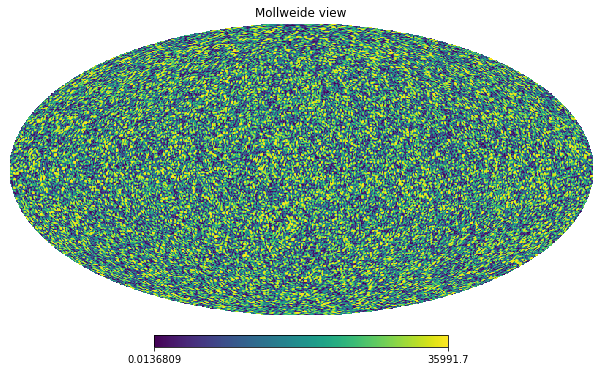

In [5]:
tmap, qmap, umap = hp.synfast(c_ell, nside, new=True)
hp.mollview(qmap**2 + umap**2,norm='hist')

## Thresholds and scalar map

We set a uniform set of thresholds from 0 to 5σ.

In [6]:
us = np.arange(0.05, 5.0, 0.05)

We separately normalise Q and U to have unit variance. In case of using a mask (`pmask`), see commented line.

In [7]:
data = mf.HealpixP2(qmap, umap, normalise=True, mask=None)   # Default parameters

# This is equivalent to the following normalisation:
# sigma = ((qmap.std()**2 + umap.std()**2)/2.)**0.5
# pmap = ((qmap/sigma)**2 + (umap/sigma)**2)
# data = mf.Healpix(pmap, normalise=False, mask=None) 

The default settings are:
 - `normalise = True`, this divides the map over the σ in such a way that we can work with adimensional `us`. Otherwise the thresholds have to be defined in an appropiate range for the given maps. We note that in this case Q and U have unit variance, while $P^2$ does not.
 - `mask = None`, as we do not have a mask. If a mask is given, the MFs are computed only within the mask (where mask=True). However, the spatial derivatives are always computed full sky in order to avoid numerical errors, so we recommend using inpainted maps or removing singularities on the maps.

## Computation of MFs

The 3 MFs can be now computed with:

In [8]:
v0 = mf.V0(data, us)
v1 = mf.V1(data, us)
v2 = mf.V2(data, us)

100%|██████████| 99/99 [00:04<00:00, 23.82it/s]


<details><summary>Information about derivatives</summary>
Before computing v1 and v2, we have to compute the first and second derivatives of the map, respectively. This is automatically done a single time upon calling and they are then stored. If one wants to compute them beforehand, it can be done with `Map.get_hessian()` (or `Map.get_gradient()` if one wants only the first derivatives).

## Computation of the Gaussian isotropic predictions

We create an instance of `TheoryP2`. This has two functions: it provides the theoretical formulae, and it averages the value within each threshold bin in order to provide a faithful comparison.

In [9]:
theo = mf.SphericalChi2(cls=c_ell[1:3], normalise=True)      # The input cls is (cls_E, cls_B)

In [10]:
v0t = mf.V0(theo, us)
v1t = mf.V1(theo, us)
v2t = mf.V2(theo, us)

## Visualization

In [11]:
def plot_V(us, v, v_theo, i='0'):
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(14,10), gridspec_kw={'height_ratios':[3,1]})
    axs[0].plot(us, v_theo, 'k--', label='Theory')
    axs[0].plot(us, v, '.', label='Map', color='C1')
    axs[0].set_ylabel(f'v{i}', size=17)
    axs[0].legend()

    axs[1].plot(us, v*0, 'k--', label='Theory')
    axs[1].plot(us, v-v_theo, '.', label='Map', color='C1')
    plt.legend()
    plt.xlabel('u', size=17)
    plt.ylabel(f'Δv{i}', size=17)
    fig.subplots_adjust(hspace=0)

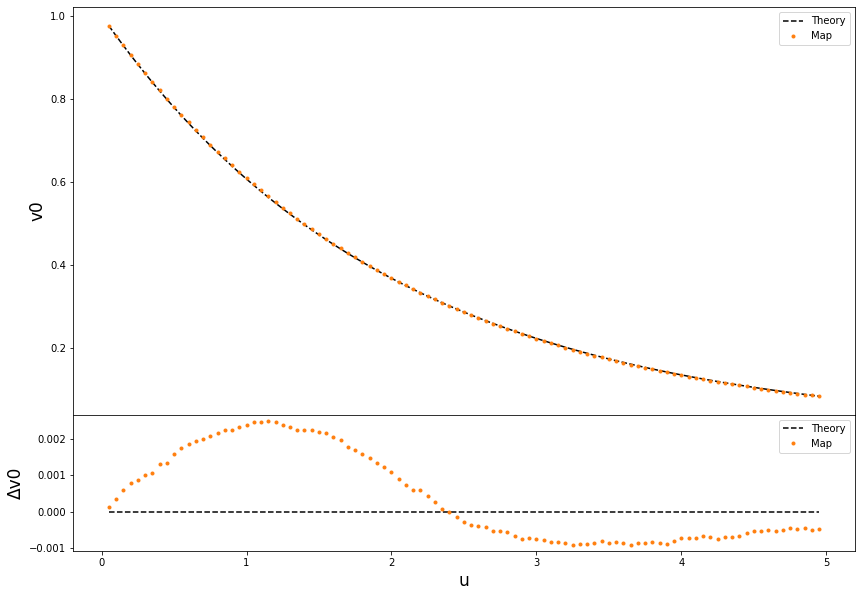

In [12]:
plot_V(us, v0, v0t, '0')

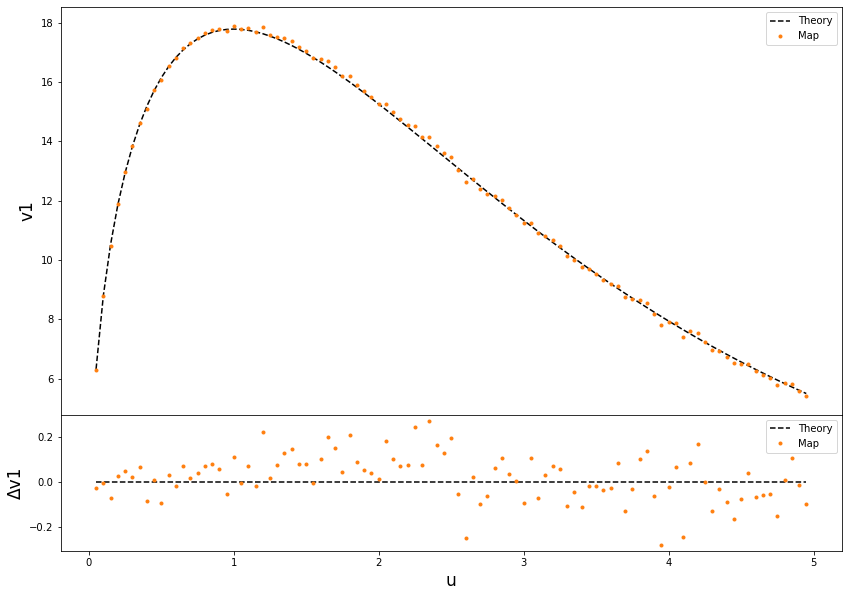

In [13]:
plot_V(us, v1, v1t, '1')

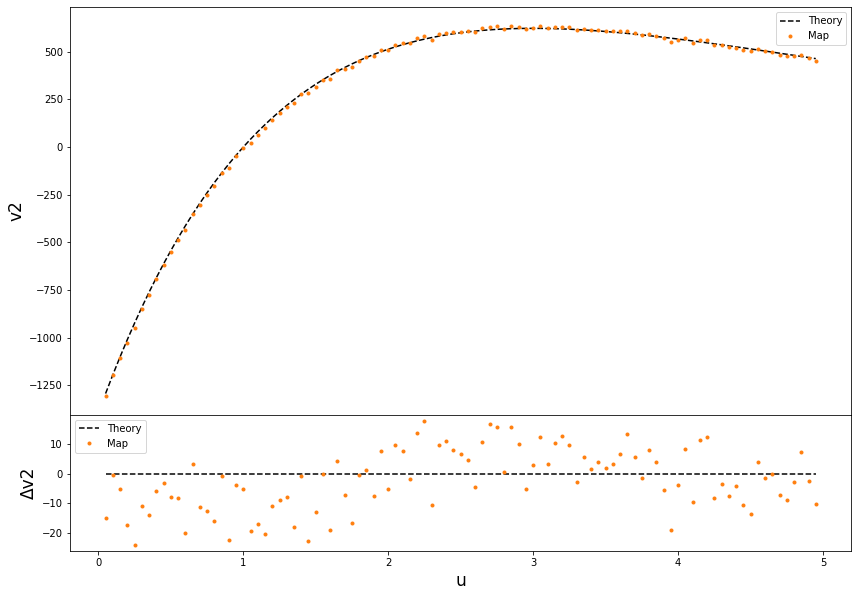

In [14]:
plot_V(us, v2, v2t, '2')

We can see that the three MFs are remarkably close to the theoretical prediction, as we are analysing a Gaussian isotropic map (because it was produced by `hp.synfast`).

`Pynkowski` has been created by Javier Carrón Duque and Alessandro Carones.

The repository can be found on https://github.com/javicarron/pynkowski

The documentation can be found on https://javicarron.github.io/pynkowski